# Binary classification

In [1]:
from pathlib import Path
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [2]:
n_samples=1000

In [3]:
X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [4]:
X.shape,y.shape

((1000, 2), (1000,))

In [5]:
print(f"5 samples of X:\n {X[:5]}")
print(f"5 samples of y:\n {y[:5]}")

5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
5 samples of y:
 [1 1 1 1 0]


(1000, 2)


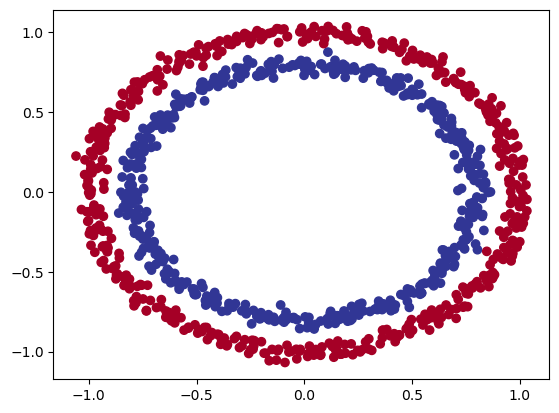

In [6]:
print(X.shape)
plt.scatter(x=X[:,[0]], #x coordinate
            y=X[:,[1]], #y coordinate
            c=y,        #color basedon y data
            cmap=plt.cm.RdYlBu
           )

In [7]:
#creating panda dataframe to see data better
circles = pd.DataFrame({"X1":X[:,0], 
                        "X2":X[:,1],
                        "label":y
                       })
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


### check input and output shapes

In [8]:

X.shape,y.shape

((1000, 2), (1000,))

In [9]:
X.dtype,y.dtype

(dtype('float64'), dtype('int64'))

In [10]:
# convert data into tensors : convert from int64 to float32 
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [11]:
X.shape,y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [12]:
type(X),X.dtype,y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

### Train test split

In [14]:
# sklearn train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
len(X_train),len(X_test)

(800, 200)

Text(0.5, 1.0, 'Train data')

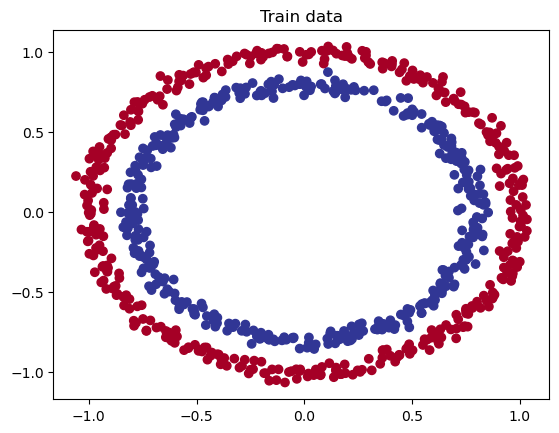

In [15]:
plt.scatter(x=X_train[:,[0]], #x coordinate
            y=X_train[:,[1]], #y coordinate
            c=y_train,        #color basedon y data
            cmap=plt.cm.RdYlBu
           )
plt.title("Train data")

Text(0.5, 1.0, 'Test data')

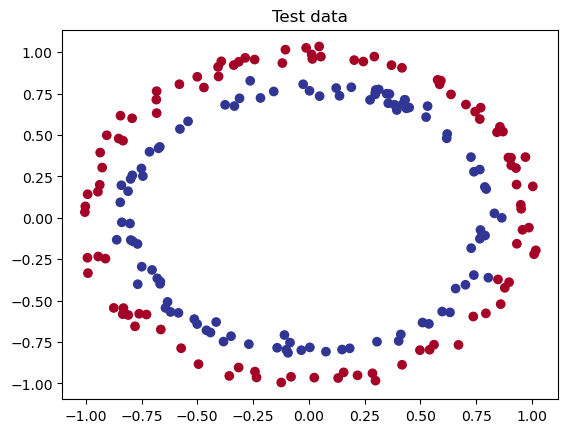

In [16]:
plt.scatter(x=X_test[:,[0]], #x coordinate
            y=X_test[:,[1]], #y coordinate
            c=y_test,        #color basedon y data
            cmap=plt.cm.RdYlBu
           )
plt.title("Test data")

### Building NN model

1. Setup device agnostic code so that it runs on GPU<br>
2. Construct a model by nn.Module<br>
3. Define Loss fn and Optimizer<br>
4. Training and test loop

In [17]:
#1. Setup device agnostic code so that it runs on GPU
import torch
from torch import nn

#make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

2. Construct a model by nn.Module
        1. Subclass nn.Module
        2. Create 2 nn.Linear()
        3. Define forward() for forward computation
        4. Instantiating instance of model class and send it to device


In [18]:
#1.Subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #2.Create 2 nn.Linear()
        self.layer_1 = nn.Linear(in_features=2,out_features=5)#takes in 2 feature into 5 neurons
        self.layer_2 = nn.Linear(in_features=5,out_features=1) # takes 5 fesature output 1
    #3.define forward
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) #x->layer1->layer2->output
#4.Instantiating instance of model class and send it to device
model_0 = CircleModelV0().to(device)
model_0
        

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
device

'cpu'

In [20]:
next(model_0.parameters()).device

device(type='cpu')

In [21]:
# create another model using sequential
model_1 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
# model_0 and model_1 both are same 

In [23]:
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2767, -0.1073],
                      [-0.0049,  0.2386],
                      [-0.0419, -0.3896],
                      [-0.0791,  0.3242],
                      [-0.2387,  0.0515]])),
             ('0.bias', tensor([ 0.5752, -0.1950, -0.1960,  0.2619, -0.5482])),
             ('1.weight',
              tensor([[-0.2764,  0.0226,  0.3965,  0.3210,  0.3670]])),
             ('1.bias', tensor([0.2099]))])

In [24]:
# make prediction
with torch.inference_mode():
    untrained_preds = model_1(X_test.to(device))
print(len(untrained_preds))
print(untrained_preds[:10])
print(y_test[:10])

200
tensor([[-0.1259],
        [-0.1457],
        [-0.1120],
        [-0.1297],
        [-0.1724],
        [-0.1841],
        [-0.1920],
        [-0.2011],
        [-0.1095],
        [-0.1477]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Define Loss fn and Optimizer

<table>
  <tr>
    <th>Loss function/Optimizer</th>
    <th>Problem type</th>
    <th>PyTorch Code</th>
  </tr>
  <tr>
    <td>Stochastic Gradient Descent (SGD) optimizer</td>
    <td>Classification, regression, many others</td>
    <td>torch.optim.SGD()</td>
  </tr>
  <tr>
    <td>Adam Optimizer</td>
    <td>Classification, regression, many others</td>
    <td>torch.optim.Adam()</td>
  </tr>
  <tr>
    <td>Binary cross entropy loss</td>
    <td>Binary classification</td>
    <td>torch.nn.BCELossWithLogits or torch.nn.BCELoss</td>
  </tr>
<tr>
    <td>Cross entropy loss</td>
    <td>Mutli-class classification</td>
    <td>torch.nn.CrossEntropyLoss</td>
  </tr>
<tr>
    <td>Mean absolute error (MAE) or L1 Loss</td>
    <td>Regression</td>
    <td>torch.nn.L1Loss</td>
  </tr>
<tr>
    <td>Mean squared error (MSE) or L2 Loss</td>
    <td>Regression</td>
    <td>torch.nn.MSELoss</td>
  </tr>
</table>

In [25]:
loss_fn = nn.BCEWithLogitsLoss() #sigmoid activation fn built in
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [26]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

### training loop

1. forward pass
2. calculate loss
3. optimize zero grad
4. loss backward propagation
5. optimizer step (gradient descent)

In [27]:
# logits : prediction of model without training
model_1.eval()
with torch.inference_mode():
    y_logits = model_1(X_test.to(device))[:5]
print(y_logits)
#use sigmoid activation fn on logits
y_pred_prob = torch.sigmoid(y_logits)
print(y_pred_prob)
#Prediction labels
print(torch.round(y_pred_prob))
print(y_test[:5])


tensor([[-0.1259],
        [-0.1457],
        [-0.1120],
        [-0.1297],
        [-0.1724]])
tensor([[0.4686],
        [0.4636],
        [0.4720],
        [0.4676],
        [0.4570]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([1., 0., 1., 0., 1.])


In [28]:
torch.manual_seed(42)
epochs=100

#tracking improvements
epoch_counts=[]
loss_values=[]
test_loss_values=[]
acc_value=[]
test_acc_value=[]

X_train, y_train = X_train.to (device), y_train.to (device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    #0 set model to training mode
    model_1.train()
    #1 forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    #2 calculate the loss
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)
#     print(loss)
    #3 optimizer zero grad
    optimizer.zero_grad()
    #4 perform back propagation on the loss
    loss.backward()
    #5 step the optimizer
    optimizer.step()
    
    #testing

    model_1.eval()
    with torch.inference_mode():
        test_logits=model_1(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)
        
    #printing    
    if epoch %5==0:
        epoch_counts.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        acc_value.append(acc)
        test_acc_value.append(test_acc)
        
        print(f"Epoch: {epoch} |Loss: {loss:.5f}, Acc: {acc:.2f}% |Test Loss: {test_loss:.5f}, test_Acc: {test_acc:.2f}%")
        
 

Epoch: 0 |Loss: 0.69614, Acc: 50.00% |Test Loss: 0.69527, test_Acc: 50.00%
Epoch: 5 |Loss: 0.69493, Acc: 50.00% |Test Loss: 0.69425, test_Acc: 50.00%
Epoch: 10 |Loss: 0.69423, Acc: 50.00% |Test Loss: 0.69370, test_Acc: 50.00%
Epoch: 15 |Loss: 0.69383, Acc: 50.00% |Test Loss: 0.69341, test_Acc: 50.00%
Epoch: 20 |Loss: 0.69360, Acc: 48.62% |Test Loss: 0.69327, test_Acc: 45.50%
Epoch: 25 |Loss: 0.69346, Acc: 42.50% |Test Loss: 0.69320, test_Acc: 46.50%
Epoch: 30 |Loss: 0.69337, Acc: 47.00% |Test Loss: 0.69319, test_Acc: 44.50%
Epoch: 35 |Loss: 0.69331, Acc: 47.62% |Test Loss: 0.69320, test_Acc: 45.50%
Epoch: 40 |Loss: 0.69327, Acc: 49.00% |Test Loss: 0.69322, test_Acc: 45.50%
Epoch: 45 |Loss: 0.69325, Acc: 49.75% |Test Loss: 0.69325, test_Acc: 46.00%
Epoch: 50 |Loss: 0.69322, Acc: 50.00% |Test Loss: 0.69328, test_Acc: 46.50%
Epoch: 55 |Loss: 0.69321, Acc: 50.38% |Test Loss: 0.69332, test_Acc: 46.00%
Epoch: 60 |Loss: 0.69319, Acc: 50.00% |Test Loss: 0.69336, test_Acc: 49.00%
Epoch: 65 |Los

In [87]:
# visualize

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [30]:
import requests
from pathlib import Path


if Path("helper_functions.py").is_file ():
    print("helper_functions.py already exists, skipping download")
else:
    print ("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.pyhttps://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary


        
        

helper_functions.py already exists, skipping download


SyntaxError: illegal target for annotation (helper_functions.py, line 1)

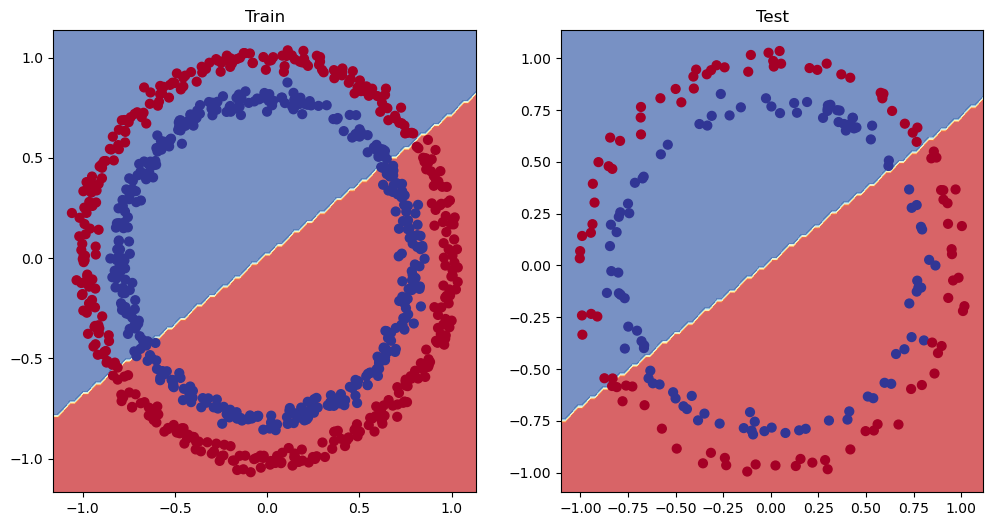

In [31]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

### improving the model

1. add more layers
2. add more hidden units
3. fit for longer
4. change the activation fn
5. change the learning rate
6. change the loss fn

In [32]:
#1.Subclass nn.Module
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        #2.Create 2 nn.Linear()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1) 
    #3.define forward
    def forward(self,x):
#         z=self.layer_1(x)
#         z=self.layer_2(z)
#         z=self.layer_3(z)
        return  self.layer_3(self.layer_2(self.layer_1(x)))
#4.Instantiating instance of model class and send it to device
model_2 = CircleModelV1().to(device)
model_2
        

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
loss_fn = nn.BCEWithLogitsLoss() #sigmoid activation fn built in
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.01)

In [34]:
torch.manual_seed(42)
epochs=1000

X_train, y_train = X_train.to (device), y_train.to (device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()
   
    y_logits = model_2(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
        
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()
   
    loss.backward()
   
    optimizer.step()
    
    #testing

    model_2.eval()
    with torch.inference_mode():
        test_logits=model_2(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)
        
    #printing    
    if epoch %100==0:
        print(f"Epoch: {epoch} |Loss: {loss:.5f}, Acc: {acc:.2f}% |Test Loss: {test_loss:.5f}, test_Acc: {test_acc:.2f}%")
        
 

Epoch: 0 |Loss: 0.69396, Acc: 50.88% |Test Loss: 0.69261, test_Acc: 51.00%
Epoch: 100 |Loss: 0.69369, Acc: 50.25% |Test Loss: 0.69269, test_Acc: 50.00%
Epoch: 200 |Loss: 0.69351, Acc: 50.12% |Test Loss: 0.69282, test_Acc: 49.50%
Epoch: 300 |Loss: 0.69339, Acc: 50.50% |Test Loss: 0.69295, test_Acc: 49.00%
Epoch: 400 |Loss: 0.69329, Acc: 50.38% |Test Loss: 0.69309, test_Acc: 48.50%
Epoch: 500 |Loss: 0.69322, Acc: 49.88% |Test Loss: 0.69322, test_Acc: 49.50%
Epoch: 600 |Loss: 0.69317, Acc: 49.50% |Test Loss: 0.69335, test_Acc: 53.00%
Epoch: 700 |Loss: 0.69313, Acc: 49.38% |Test Loss: 0.69347, test_Acc: 50.50%
Epoch: 800 |Loss: 0.69309, Acc: 50.00% |Test Loss: 0.69358, test_Acc: 51.00%
Epoch: 900 |Loss: 0.69307, Acc: 50.62% |Test Loss: 0.69368, test_Acc: 47.50%


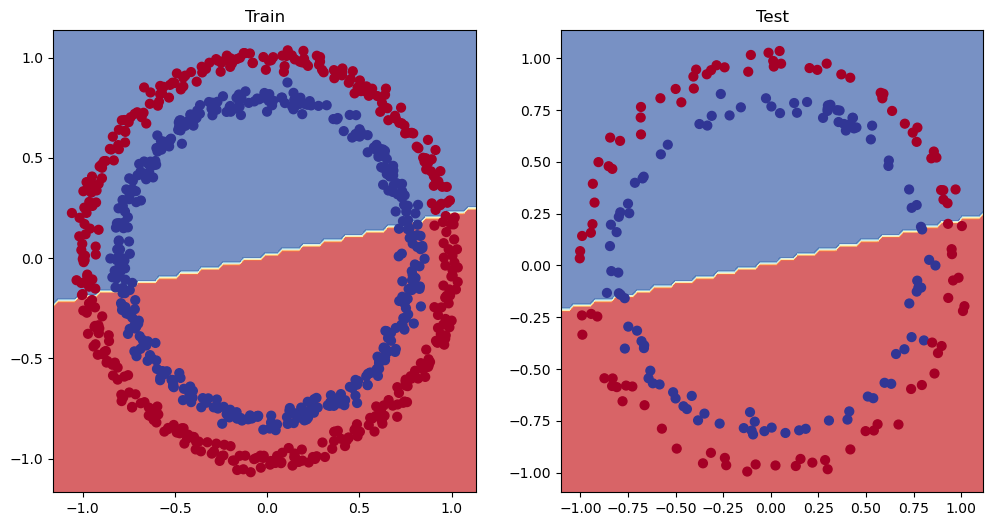

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test,y_test)

## model is not learning we tried.

1. adding  more layers
2. add more hidden units
3. fit for longer
4. change the learning rate


## now we use non linear activation function
1. change the activation fn
2. change the loss fn

In [40]:
#1.Subclass nn.Module
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        #2.Create 2 nn.nonLinear()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1) 
        self.relu=nn.ReLU() #non linear activation fn
    #3.define forward
    def forward(self,x):
        return  self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
#4.Instantiating instance of model class and send it to device
model_3 = CircleModelV2().to(device)
model_3
       

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [41]:
loss_fn = nn.BCEWithLogitsLoss() #sigmoid activation fn built in
optimizer = torch.optim.SGD(params=model_3.parameters(),lr=0.1)

In [42]:
torch.manual_seed(42)
epochs=1000

X_train, y_train = X_train.to (device), y_train.to (device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
   
    y_logits = model_3(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
        
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()
   
    loss.backward()
   
    optimizer.step()
    
    #testing

    model_3.eval()
    with torch.inference_mode():
        test_logits=model_3(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)
        
    #printing    
    if epoch %100==0:
        print(f"Epoch: {epoch} |Loss: {loss:.5f}, Acc: {acc:.2f}% |Test Loss: {test_loss:.5f}, test_Acc: {test_acc:.2f}%")
        
 

Epoch: 0 |Loss: 0.69295, Acc: 50.00% |Test Loss: 0.69319, test_Acc: 50.00%
Epoch: 100 |Loss: 0.69115, Acc: 52.88% |Test Loss: 0.69102, test_Acc: 52.50%
Epoch: 200 |Loss: 0.68977, Acc: 53.37% |Test Loss: 0.68940, test_Acc: 55.00%
Epoch: 300 |Loss: 0.68795, Acc: 53.00% |Test Loss: 0.68723, test_Acc: 56.00%
Epoch: 400 |Loss: 0.68517, Acc: 52.75% |Test Loss: 0.68411, test_Acc: 56.50%
Epoch: 500 |Loss: 0.68102, Acc: 52.75% |Test Loss: 0.67941, test_Acc: 56.50%
Epoch: 600 |Loss: 0.67515, Acc: 54.50% |Test Loss: 0.67285, test_Acc: 56.00%
Epoch: 700 |Loss: 0.66659, Acc: 58.38% |Test Loss: 0.66322, test_Acc: 59.00%
Epoch: 800 |Loss: 0.65160, Acc: 64.00% |Test Loss: 0.64757, test_Acc: 67.50%
Epoch: 900 |Loss: 0.62362, Acc: 74.00% |Test Loss: 0.62145, test_Acc: 79.00%


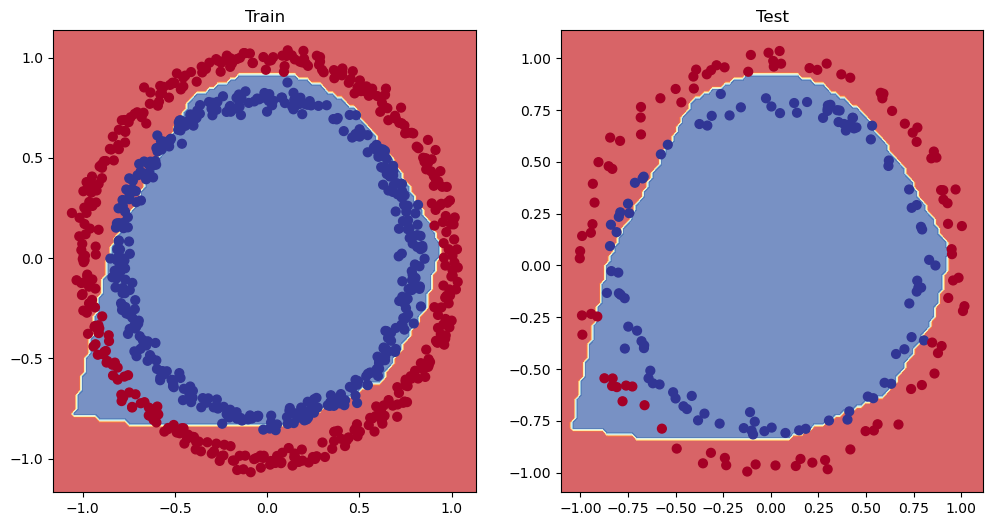

In [43]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

## now our model is learning 
1. lets add more layers and hidden units and train it for longer

In [62]:
#1.Subclass nn.Module
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        #2.Create 2 nn.nonLinear()
        self.layer_1 = nn.Linear(in_features=2,out_features=64)
        self.layer_2 = nn.Linear(in_features=64,out_features=64)
        self.layer_3 = nn.Linear(in_features=64,out_features=64)
        self.layer_4 = nn.Linear(in_features=64,out_features=1) 
        self.relu=nn.ReLU() #non linear activation fn
    #3.define forward
    def forward(self,x):
        return  self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))
#4.Instantiating instance of model class and send it to device
model_4 = CircleModelV3().to(device)
model_4

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [63]:
loss_fn = nn.BCEWithLogitsLoss() #sigmoid activation fn built in
optimizer = torch.optim.SGD(params=model_4.parameters(),lr=0.1)

In [64]:
torch.manual_seed(42)
epochs=1000

X_train, y_train = X_train.to (device), y_train.to (device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_4.train()
   
    y_logits = model_4(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
        
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()
   
    loss.backward()
   
    optimizer.step()
    
    #testing

    model_4.eval()
    with torch.inference_mode():
        test_logits=model_4(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)
        
    #printing    
    if epoch %100==0:
        print(f"Epoch: {epoch} |Loss: {loss:.5f}, Acc: {acc:.2f}% |Test Loss: {test_loss:.5f}, test_Acc: {test_acc:.2f}%")
        
 

Epoch: 0 |Loss: 0.69326, Acc: 50.00% |Test Loss: 0.69337, test_Acc: 50.00%
Epoch: 100 |Loss: 0.68550, Acc: 63.88% |Test Loss: 0.68800, test_Acc: 64.00%
Epoch: 200 |Loss: 0.67545, Acc: 70.12% |Test Loss: 0.68119, test_Acc: 64.50%
Epoch: 300 |Loss: 0.64696, Acc: 80.12% |Test Loss: 0.65877, test_Acc: 73.00%
Epoch: 400 |Loss: 0.51840, Acc: 98.75% |Test Loss: 0.54539, test_Acc: 97.50%
Epoch: 500 |Loss: 0.43809, Acc: 71.00% |Test Loss: 0.48979, test_Acc: 63.50%
Epoch: 600 |Loss: 0.31078, Acc: 84.38% |Test Loss: 0.38632, test_Acc: 77.50%
Epoch: 700 |Loss: 0.04068, Acc: 100.00% |Test Loss: 0.06658, test_Acc: 100.00%
Epoch: 800 |Loss: 0.01990, Acc: 100.00% |Test Loss: 0.03843, test_Acc: 100.00%
Epoch: 900 |Loss: 0.01246, Acc: 100.00% |Test Loss: 0.02720, test_Acc: 100.00%


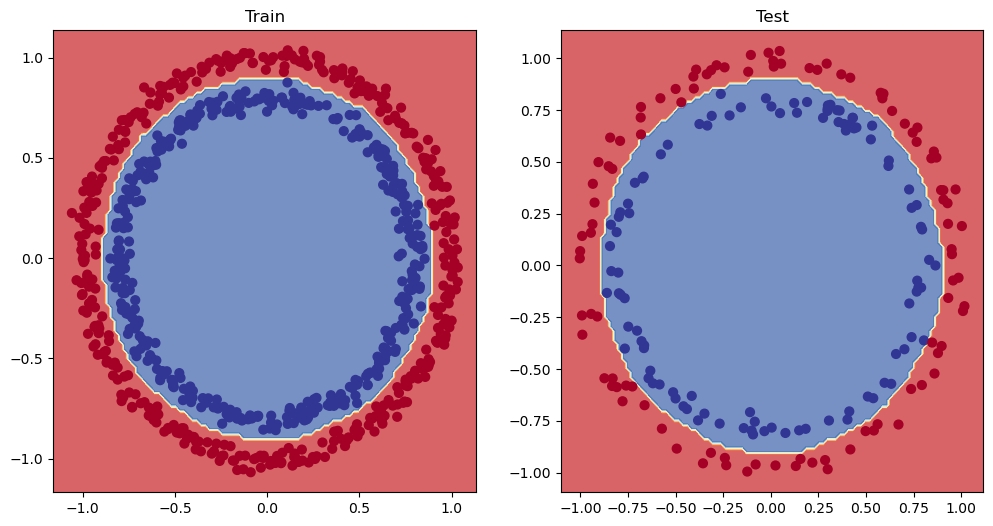

In [65]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_test,y_test)

# Multiclass classification

In [56]:
from pathlib import Path
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [57]:
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

In [58]:
#1 create multiclass dataset
X_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=NUM_FEATURES, 
                         centers= NUM_CLASSES,
                         cluster_std=1.5,
                         random_state=RANDOM_SEED
                        )
#2 turn data into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [59]:
print(f"Features:  {X_blob[0]}  : {len(X_blob[0])}")
print(f"Classes:  {y_blob.unique()}  : {len(y_blob.unique())}")

Features:  tensor([-8.4134,  6.9352])  : 2
Classes:  tensor([0, 1, 2, 3])  : 4


In [60]:
#3 Train test split
X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,
                                                                     y_blob,
                                                                     test_size=0.2,
                                                                     random_state=RANDOM_SEED)

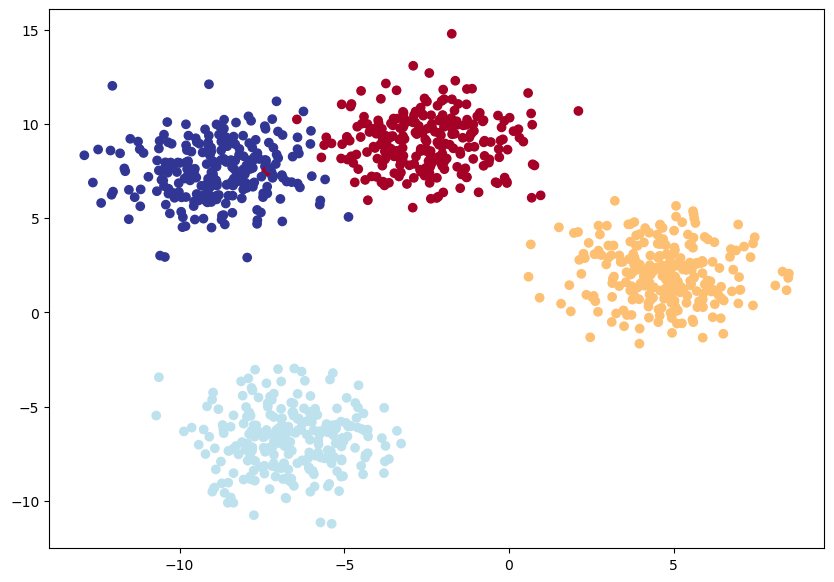

In [61]:
#visuals
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

### building multiclass classification model

In [62]:
### building multiclass classification model

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [63]:
# building model sub class
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """ Initialization multi-class classification model
        Args:
            input_features : number of features
            output_features: number of classes
            hidden_units: number of hidden units in layers
        
        Returns:
        
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        
        )
            
    def forward(self,x):
            return self.linear_layer_stack(x)
        

In [64]:
print(f"Features:  {X_blob[0]}  : {len(X_blob[0])}")
print(f"Classes:  {y_blob.unique()}  : {len(y_blob.unique())}")

Features:  tensor([-8.4134,  6.9352])  : 2
Classes:  tensor([0, 1, 2, 3])  : 4


In [65]:
#create instance of model
model_5 = BlobModel(input_features=len(X_blob[0]),
                    output_features=len(y_blob.unique()),
                    hidden_units=8
                   ).to(device)

model_5

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [66]:
# Create a loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_5.parameters(),lr=0.1)

In [73]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## test our model without training

In [67]:
## testing raw predicction without training
model_5.eval()
with torch.inference_mode():
    y_logits = model_5(X_blob_test.to(device))

print(f"logits: \n{y_logits[:10]}")
print(f"y_blob_test:{y_blob_test[:10]}")
print("we need to converts logits into labels so that it matches the y_blob_test")

logits: 
tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])
y_blob_test:tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
we need to converts logits into labels so that it matches the y_blob_test


In [68]:
y_preds=torch.argmax(y_preds_prob,dim=1)
y_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [69]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### clearly our model is not predicting

## Train test Loop

In [74]:
torch.manual_seed(42)
epochs=100

X_blob_train, y_blob_train = X_blob_train.to (device), y_blob_train.to (device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_5.train()
    
    y_logits = model_5(X_blob_train)
    y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
    
        
    loss=loss_fn(y_logits,y_blob_train)
    acc=accuracy_fn(y_true=y_blob_train,y_pred=y_preds)

    optimizer.zero_grad()
   
    loss.backward()
   
    optimizer.step()
    
    #testing

    model_5.eval()
    with torch.inference_mode():
        test_logits=model_5(X_blob_test)
        test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
        
        test_loss=loss_fn(test_logits,y_blob_test)
        test_acc=accuracy_fn(y_true=y_blob_test,y_pred=test_pred)
        
    #printing    
    if epoch %10==0:
        print(f"Epoch: {epoch} |Loss: {loss:.4f}, Acc: {acc:.2f}% |Test Loss: {test_loss:.4f}, test_Acc: {test_acc:.2f}%")
        
 

Epoch: 0 |Loss: 1.1588, Acc: 40.38% |Test Loss: 1.0755, test_Acc: 48.00%
Epoch: 10 |Loss: 0.6448, Acc: 96.75% |Test Loss: 0.6607, test_Acc: 97.50%
Epoch: 20 |Loss: 0.4254, Acc: 98.50% |Test Loss: 0.4307, test_Acc: 100.00%
Epoch: 30 |Loss: 0.2529, Acc: 99.12% |Test Loss: 0.2451, test_Acc: 99.50%
Epoch: 40 |Loss: 0.1123, Acc: 99.25% |Test Loss: 0.1023, test_Acc: 99.50%
Epoch: 50 |Loss: 0.0663, Acc: 99.25% |Test Loss: 0.0585, test_Acc: 99.50%
Epoch: 60 |Loss: 0.0507, Acc: 99.25% |Test Loss: 0.0429, test_Acc: 99.50%
Epoch: 70 |Loss: 0.0430, Acc: 99.25% |Test Loss: 0.0349, test_Acc: 99.50%
Epoch: 80 |Loss: 0.0384, Acc: 99.25% |Test Loss: 0.0299, test_Acc: 99.50%
Epoch: 90 |Loss: 0.0352, Acc: 99.25% |Test Loss: 0.0266, test_Acc: 99.50%


### check prediction

In [75]:
## testing raw predicction without training
model_5.eval()
with torch.inference_mode():
    y_logits = model_5(X_blob_test)

print(f"logits: \n{y_logits[:10]}")
print(f"y_blob_test:{y_blob_test[:10]}")
print("we need to converts logits into labels so that it matches the y_blob_test")

logits: 
tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])
y_blob_test:tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
we need to converts logits into labels so that it matches the y_blob_test


In [81]:
y_preds_probs=torch.softmax(y_logits,dim=1)
y_preds_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]])

In [83]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [85]:
y_preds=torch.argmax(y_preds_probs,dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [86]:
y_blob_test==y_preds

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

## Visualize

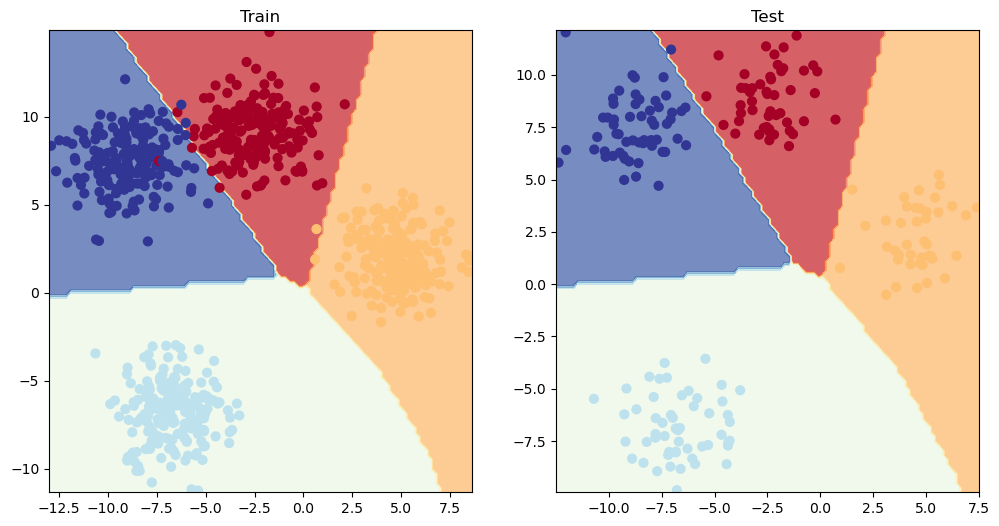

In [92]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_5,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_5,X_blob_test,y_blob_test)
plt.show()

## we can remove ReLu from the model because our data can be seperated by linear lines. so no need of non-linear activation fn